In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

  Cloning https://github.com/sevamoo/SOMPY to /tmp/pip-req-build-6atux6pb
  Running command git clone -q https://github.com/sevamoo/SOMPY /tmp/pip-req-build-6atux6pb
  Created wheel for SOMPY: filename=SOMPY-1.1-cp36-none-any.whl size=28115 sha256=129efd9b55ab1fcd8b8668d0907d5082fbb542bd981b5180c4e6b8177e5b16e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ohkqt9kh/wheels/89/eb/f9/61aa37e7c35ddc5fdaeb57dae54241a1a80bdd472cce3024fa
Successfully built SOMPY


In [0]:
link = 'https://drive.google.com/open?id=1xI1wxYPp49kqz1OsJKDrRvBfruOM-QPp'
fluff, id = link.split('=')

Se leen los datos, que corresponden a la base de datos de Kaggle: 

https://www.kaggle.com/jeanmidev/smart-meters-in-london

, que corresponde a una serie de medidores de electricidad por hora en Londres. La finalidad de este análisis será realizar un clustering sobre las series temporales para observar los distintos perfiles que tienen los consumidores de energía.

In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Base_Limpia.csv')  
df = pd.read_csv('Base_Limpia.csv')

In [6]:
df.head()

,Unnamed: 0,index,LCLid,KWh,Day,Month,Year,Hour,stdorToU,Acorn,DayOfWeek,DayOfYear,Weekend,AcornDescription,AcornName,AcornDesc
0,0,0,MAC000002,0.0,12,10,2012,0.5,Std,A,4,286,0,NaN,Lavish Lifestyles,Exclusive enclaves : Metropolitan money : Larg...
1,1,1,MAC000002,0.0,12,10,2012,1.0,Std,A,4,286,0,NaN,Lavish Lifestyles,Exclusive enclaves : Metropolitan money : Larg...
2,2,2,MAC000002,0.0,12,10,2012,1.5,Std,A,4,286,0,NaN,Lavish Lifestyles,Exclusive enclaves : Metropolitan money : Larg...
3,3,3,MAC000002,0.0,12,10,2012,2.0,Std,A,4,286,0,NaN,Lavish Lifestyles,Exclusive enclaves : Metropolitan money : Larg...
4,4,4,MAC000002,0.0,12,10,2012,2.5,Std,A,4,286,0,NaN,Lavish Lifestyles,Exclusive enclaves : Metropolitan money : Larg...


Un vistazo a la base de datos nos permite observar una serie de variables, las cuales en este análisis serán de utilidad:

LCLid: que corresponde al elemento identificador

KWh: la energía consumida

Day, Hour: Variables con las que realizaremos una media para observar su comportamiento por días y por horas

El resto de variables se postergarán para un posible análisis futuro más profundo.

Para este primer análisis se juntarán todos los días y se realizará la media entre ellos, por cada Id

In [0]:
df2 = df.groupby([df['DayOfWeek'],df['LCLid'],df['Hour']]).mean()
df2 = df2.reset_index()

In [0]:
df2= df2.loc[:,['LCLid','KWh', 'DayOfWeek','Hour']]

Dado que las observaciones se encuentran en forma de columnas se van a pasar a filas:

In [0]:
df2['g'] = df2.groupby(['LCLid']).cumcount()
df3 = df2.set_index(['LCLid', 'g']).unstack(fill_value=0).sort_index(axis=1, level=1)

In [0]:
del df3['DayOfWeek'],df3['Hour']

In [13]:
df3

KWh                      ...                              
g               0         1         2    ...       333       334       335
LCLid                                    ...                              
MAC000002  0.299672  0.258484  0.234906  ...  0.319641  0.313797  0.314844
MAC000003  1.087732  1.774505  1.532206  ...  0.134474  0.121887  0.112567
MAC000004  0.040733  0.030105  0.034023  ...  0.024570  0.042163  0.031209
MAC000006  0.032610  0.030480  0.029610  ...  0.050850  0.046580  0.037720
MAC000007  0.090015  0.072121  0.064970  ...  0.256348  0.182409  0.133758
...             ...       ...       ...  ...       ...       ...       ...
MAC000463  0.142049  0.129537  0.135646  ...  0.452793  0.266098  0.177707
MAC000466  0.098419  0.099172  0.097860  ...  0.132667  0.109204  0.100645
MAC000468  0.344527  0.322462  0.302849  ...  0.429247  0.403172  0.377946
MAC000469  0.232323  0.194774  0.207323  ...  0.298806  0.252548  0.249097
MAC000471  0.147634  0.139828  0.125946  ...  0.221516  0.189462  0.162409

[390 rows x 336 columns]

Por último, se realizará la porporción de consumo de cada día con respecto al total semanal, sumando todos los lunes, martes, miércoles... y dividiéndolo entre el total consumido en la semana

In [0]:
df_s = df3.div(df3.sum(axis=1), axis=0)

# Normalizar

Se han hecho pruebas normalizando los datos, aunque los resultados no arrojaban conclusiones mejores que con el método que se propone.

In [0]:
# from sklearn import preprocessing
# s_scaler = preprocessing.StandardScaler()
# df_s = s_scaler.fit_transform(df3)

# df_s = pd.DataFrame(df_s, columns=df3.columns)

# Outliers

Se puede utilizar el propio algoritmo de kMeans para detectar outliers, aunque no es del todo adecuado ni recomendable. 

Lo primero será calcular la silueta que tiene la base de datos para los clústeres que se proponen, hasta un número máximo de 10

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
matrix = df_s.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


For n_clusters = 2 The average silhouette_score is : 0.8593771898306022
For n_clusters = 3 The average silhouette_score is : 0.6416517061426809
For n_clusters = 4 The average silhouette_score is : 0.6081417582733437
For n_clusters = 5 The average silhouette_score is : 0.12213321402470716
For n_clusters = 6 The average silhouette_score is : 0.11174672990990905
For n_clusters = 7 The average silhouette_score is : 0.11019339932833443
For n_clusters = 8 The average silhouette_score is : 0.10141446826018681
For n_clusters = 9 The average silhouette_score is : 0.09107293845363962


El número adecuado de clústeres según esta técnica sería de entre 2 y 4, pero para detectar estos outliers se elegirá uno de 5, pues es el momento en el que la silueta decrece notablemente

In [37]:
n_clusters = 5
silhouette_avg = -1
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.12325517190261483


Mostramos la cantidad de observaciones que hay en cada clúster

In [38]:
pd.Series(clusters).value_counts()

1    194
3    184
0     10
4      1
2      1
dtype: int64

Se eliminan aquellos pertenecientes a los clústeres 2 y 4, puesto que se encuentran en un clúster individual y no encajan en ningún otro, por lo que se podría considerar un outlier

In [0]:
df3['clusters']=clusters

In [0]:
i = df3[((df3.clusters==2)|(df3.clusters==4))].index
df4 = df3.drop(i)
del df4['clusters']

Una vez eliminados estas observaciones, se realiza el clúster de nuevo

# Segundo cluster

In [0]:
# from sklearn import preprocessing
# s_scaler = preprocessing.StandardScaler()
# df_s = s_scaler.fit_transform(df4)

# df_s = pd.DataFrame(df_s, columns=df4.columns)
df_s = df4.div(df4.sum(axis=1), axis=0)

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
matrix = df_s.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


For n_clusters = 2 The average silhouette_score is : 0.6112765096046496
For n_clusters = 3 The average silhouette_score is : 0.12389050784025717
For n_clusters = 4 The average silhouette_score is : 0.11074058600277344
For n_clusters = 5 The average silhouette_score is : 0.10987636017508622
For n_clusters = 6 The average silhouette_score is : 0.08981133003736942
For n_clusters = 7 The average silhouette_score is : 0.08505115823904645
For n_clusters = 8 The average silhouette_score is : 0.09426850461320169
For n_clusters = 9 The average silhouette_score is : 0.07125858960054364


Se elige un número de clústers de 4. El número de clústers a elegir depende no solo del criterio de la silueta, sino también de los grupos que se pretendan diferenciar, ya sean definidos por el propio analista o por clientes.

Elegiremos 4 grupos puesto que queremos tener un número lo suficientemente grande como para poder realizar un análisis de cada uno de los perfiles.

In [44]:
n_clusters = 4
silhouette_avg = -1
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 4 The average silhouette_score is : 0.11232274398160959


In [45]:
pd.Series(clusters).value_counts()

1    153
2    117
0    110
3      8
dtype: int64

In [0]:
df4['clusters']=clusters

Se realzia un gráfico de cada uno de los perfiles, ordenados por el tamaño de individuos en cada clúster

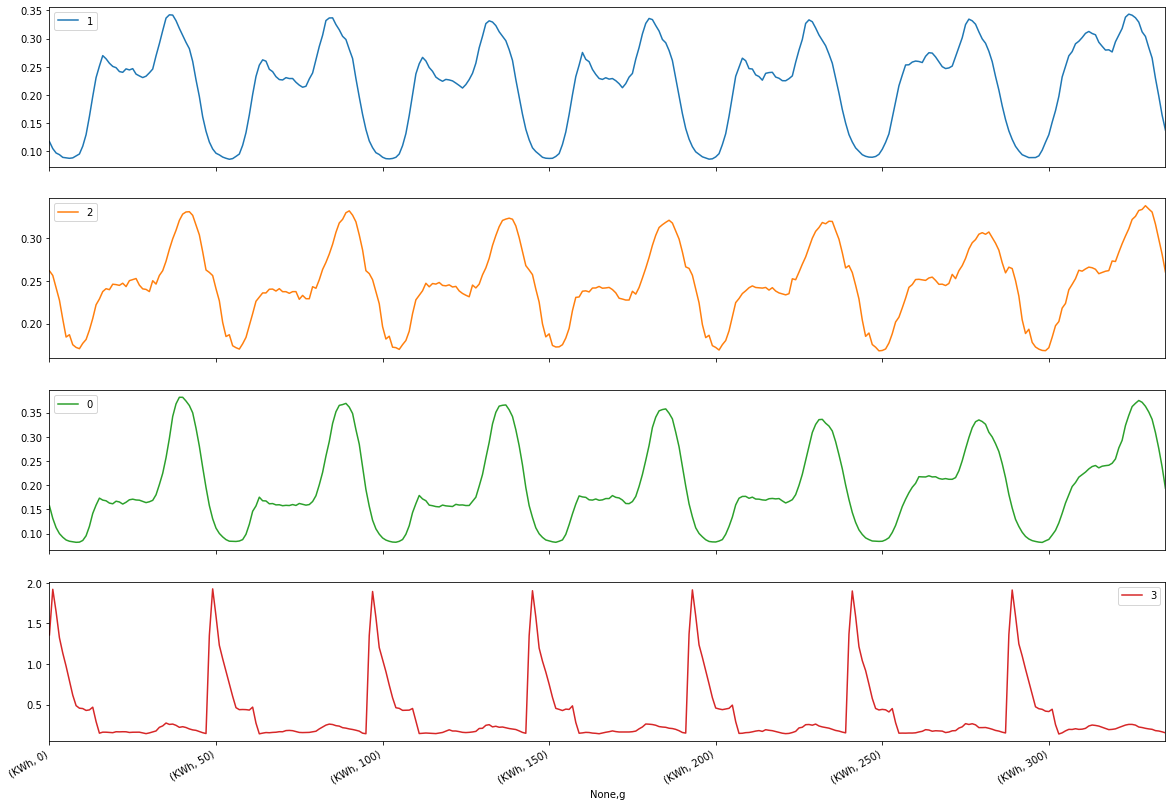

In [47]:
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
np.transpose(df4.groupby('clusters').mean().iloc[pd.array(pd.Series(clusters).value_counts().reset_index()['index']),0:len(df4)]).plot(subplots=True )
plt.show()

Se pueden diferenciar los perfiles siguientes:

Primer clúster: Se podría englobar en este clúster al hogar medio, que posee un consumo bajo por las mañanas y va creciendo por las tardes hasta alcanzar un pico en la noche

Segundo clúster: Dentro de este se podría pensar, de nuevo, en los hogares pero, a diferencia del primero, su consumo se concentra más por la noche. Es posible que dentro de este clúster haya más de un grupo que podría ser sacado del mismo.

Tercer clúster: Es un clúster que llega al extremo de consumir por la noche en su mayor parte

Cuarto clúster: Consume a altas horas de la noche. Se podría atribuir a la industria

# Centroides

Se va a realizar un gráfico de los centroides de cada clúster, para observar un gráfico del individuo más representativo 

In [0]:
import numpy as np
centroids  = kmeans.cluster_centers_ 
centroid_labels = [centroids[i] for i in df4['clusters']]
centroid_labels = pd.DataFrame(centroid_labels)
df_final = df4.drop(['clusters'], axis=1)
centroid_labels.columns=df_final.columns
centroid_labels.index = df_final.index
df_final['dist'] = np.sqrt(((df_final.subtract(centroid_labels))*(df_final.subtract(centroid_labels))).sum(axis=1))
df_final = pd.concat([df_final.reset_index(drop=True), pd.DataFrame(clusters)], axis=1, join='outer')
df_final.index = df4.index 

In [0]:
df_final.columns = range(len(df_final.columns))

In [75]:
series

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337
LCLid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MAC000325,0.036573,0.027708,0.021730,0.015685,0.011753,0.009045,0.007438,0.004899,0.004663,0.004258,0.002708,0.001831,0.001708,0.003640,0.002461,0.002798,0.004742,0.004303,0.004989,0.003146,0.006247,0.006652,0.006045,0.007034,0.007494,0.008719,0.009303,0.009831,0.010506,0.010899,0.010056,0.011146,0.011775,0.012820,0.012989,0.013281,0.013775,0.017685,0.017416,0.018427,...,0.008292,0.006910,0.006899,0.005427,0.006517,0.006404,0.005551,0.005899,0.005124,0.006764,0.007348,0.009449,0.012112,0.011562,0.015135,0.019640,0.021404,0.020438,0.021843,0.026663,0.022506,0.028315,0.026921,0.028393,0.028528,0.027798,0.028921,0.032124,0.031427,0.031966,0.032888,0.036000,0.038798,0.039551,0.041787,0.047730,0.047281,0.041820,0.214618,0
MAC000016,0.015964,0.014691,0.016382,0.011945,0.008800,0.012800,0.010673,0.009655,0.010982,0.011055,0.009964,0.009855,0.010836,0.013182,0.014473,0.014836,0.018727,0.022727,0.026291,0.026345,0.026782,0.047091,0.039836,0.033145,0.026109,0.021418,0.020655,0.022055,0.023927,0.021727,0.023709,0.022855,0.023745,0.024782,0.026127,0.026782,0.029800,0.035127,0.028927,0.028891,...,0.010236,0.009564,0.011091,0.014618,0.011073,0.015800,0.018400,0.023873,0.022418,0.022582,0.020964,0.027218,0.027782,0.024964,0.039291,0.046364,0.037673,0.043455,0.030964,0.027964,0.030273,0.029764,0.034764,0.036527,0.034418,0.033036,0.032000,0.032709,0.030418,0.030691,0.032091,0.032364,0.031818,0.024382,0.023036,0.024236,0.022018,0.017782,0.358386,1
MAC000004,0.040733,0.030105,0.034023,0.031349,0.035605,0.041000,0.027081,0.038488,0.044372,0.022628,0.044465,0.025116,0.027872,0.045140,0.037698,0.036395,0.029244,0.038698,0.051558,0.053640,0.036035,0.043733,0.041791,0.043453,0.050791,0.039581,0.041093,0.029070,0.030535,0.041116,0.035570,0.037221,0.039395,0.027500,0.024244,0.048267,0.040802,0.042767,0.018430,0.021709,...,0.046291,0.036221,0.020256,0.031140,0.027209,0.068465,0.042233,0.039953,0.024593,0.041093,0.048314,0.062523,0.027814,0.034407,0.036174,0.053384,0.050453,0.033942,0.030128,0.039233,0.040221,0.061023,0.028151,0.021488,0.040895,0.040721,0.047616,0.030256,0.023895,0.037744,0.041674,0.037174,0.043244,0.036337,0.035337,0.024570,0.042163,0.031209,0.612902,2
MAC000350,0.858232,0.758158,0.253558,0.223853,0.186589,0.154095,0.132358,0.099937,0.126200,0.127526,0.124242,0.094558,0.099705,0.115526,0.090832,0.085021,0.098168,0.113147,0.111842,0.116179,0.114632,0.126253,0.124642,0.127505,0.152021,0.172789,0.190758,0.210884,0.187611,0.200200,0.178400,0.192411,0.161095,0.183895,0.175126,0.197442,0.160126,0.155705,0.164053,0.152137,...,0.117284,0.097505,0.092032,0.106116,0.087811,0.076926,0.083200,0.097326,0.108105,0.120958,0.119716,0.120358,0.127126,0.129263,0.138716,0.150337,0.153484,0.195558,0.202695,0.195758,0.181758,0.176053,0.158747,0.181747,0.195084,0.166989,0.151611,0.163284,0.154316,0.166621,0.144737,0.147642,0.142484,0.139105,0.108811,0.097526,0.098400,0.087074,4.066854,3


In [0]:
series = df_final.sort_values([337,336,], ascending=[True,True]).drop_duplicates(337) 

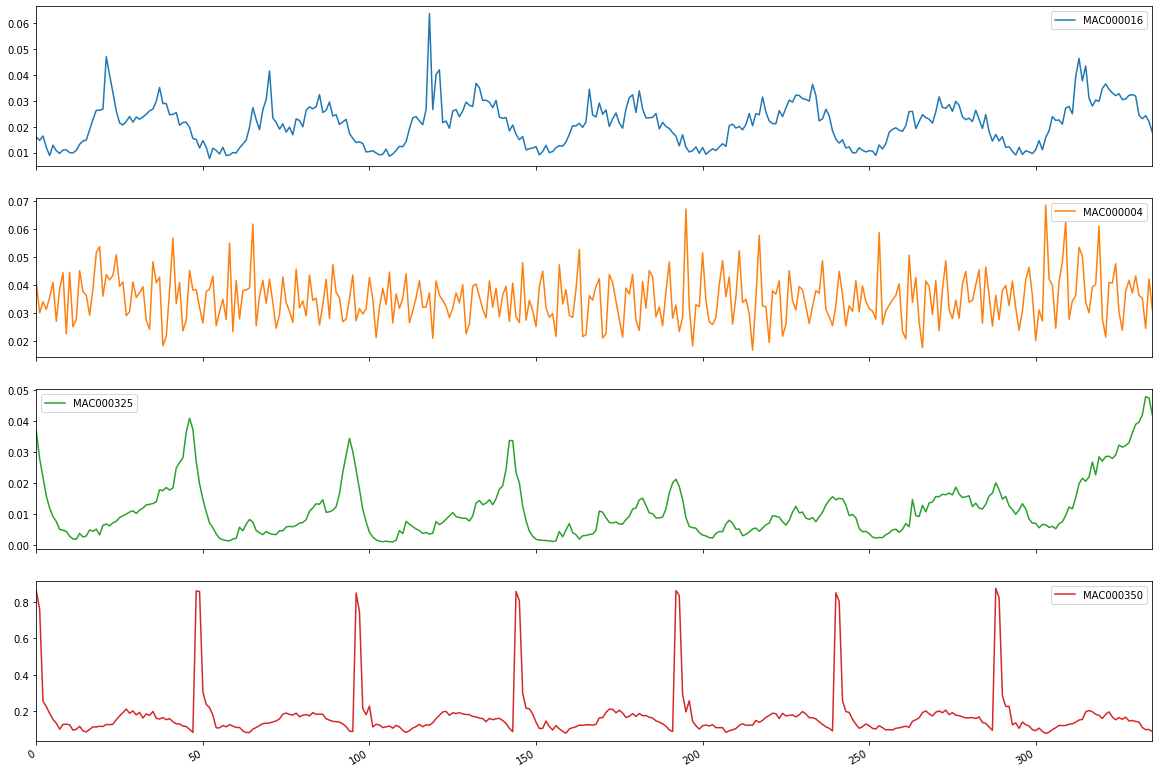

In [79]:
np.transpose(series.iloc[pd.array(pd.Series(clusters).value_counts().reset_index()['index']),0:(series.shape[1]-2)]).plot(subplots=True)
plt.show()

En este caso no arrojan posibles explicaciones acerca de los clústeres

# Media por horas

El mismo análisis realizado sobre la media de los días se ejecutará ahora sobre la media por horas.

In [0]:
df2 = df.groupby([df['LCLid'],df['Hour']]).mean()
df2 = df2.reset_index()

In [0]:
df2= df2.loc[:,['LCLid','KWh', 'Hour']]

In [0]:
df2['g'] = df2.groupby(['LCLid']).cumcount()
df3 = df2
df3 = df3.set_index(['LCLid', 'g']).unstack(fill_value=0).sort_index(axis=1, level=1)
del df3['Hour']

In [0]:
df_s = df3.div(df3.sum(axis=1), axis=0)

# Normalizar

In [0]:
# from sklearn import preprocessing
# df_s = pd.DataFrame(preprocessing.normalize(df3))
# # df_s = s_scaler.fit_transform(df3)
# # df_s = pd.DataFrame(s_scaler, columns=df3.columns)
# df_s.index = df3.index

# Outliers

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
matrix = df_s.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


For n_clusters = 2 The average silhouette_score is : 0.6702789977012006
For n_clusters = 3 The average silhouette_score is : 0.6745826393854629
For n_clusters = 4 The average silhouette_score is : 0.1727572073166047
For n_clusters = 5 The average silhouette_score is : 0.16048759015516859
For n_clusters = 6 The average silhouette_score is : 0.1546631511136686
For n_clusters = 7 The average silhouette_score is : 0.1364214340697189
For n_clusters = 8 The average silhouette_score is : 0.1359717476707996
For n_clusters = 9 The average silhouette_score is : 0.13358957794647644


In [0]:
n_clusters = 9
silhouette_avg = -1
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 9 The average silhouette_score is : 0.1381021059364462


In [0]:
pd.Series(clusters).value_counts()

0    88
1    79
7    76
3    64
8    54
6    16
5     6
2     6
4     1
dtype: int64

In [0]:
df3['clusters']=clusters

In [0]:
j = pd.array(pd.Series(clusters).value_counts().reset_index()['index'])[-1]
k = pd.array(pd.Series(clusters).value_counts().reset_index()['index'])[-2]
i = df3[(df3.clusters==j)|(df3.clusters==k)].index
df4 = df3.drop(i)

# Segundo cluster

In [0]:
# from sklearn import preprocessing
# df_s = pd.DataFrame(preprocessing.normalize(df4))
# # df_s = s_scaler.fit_transform(df3)
# # df_s = pd.DataFrame(s_scaler, columns=df3.columns)
# df_s.index = df4.index

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
matrix = df_s.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


For n_clusters = 2 The average silhouette_score is : 0.6597798085088469
For n_clusters = 3 The average silhouette_score is : 0.6745826393854629
For n_clusters = 4 The average silhouette_score is : 0.1727572073166047
For n_clusters = 5 The average silhouette_score is : 0.16048759015516859
For n_clusters = 6 The average silhouette_score is : 0.161206210221381
For n_clusters = 7 The average silhouette_score is : 0.13789442748441458
For n_clusters = 8 The average silhouette_score is : 0.1380082563156158
For n_clusters = 9 The average silhouette_score is : 0.13687325257294386


In [0]:
n_clusters = 6
silhouette_avg = -1
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.1588391281160911


In [0]:
pd.Series(clusters).value_counts()

5    111
3    108
0     99
1     63
2      8
4      1
dtype: int64

In [0]:
df3['clusters']=clusters

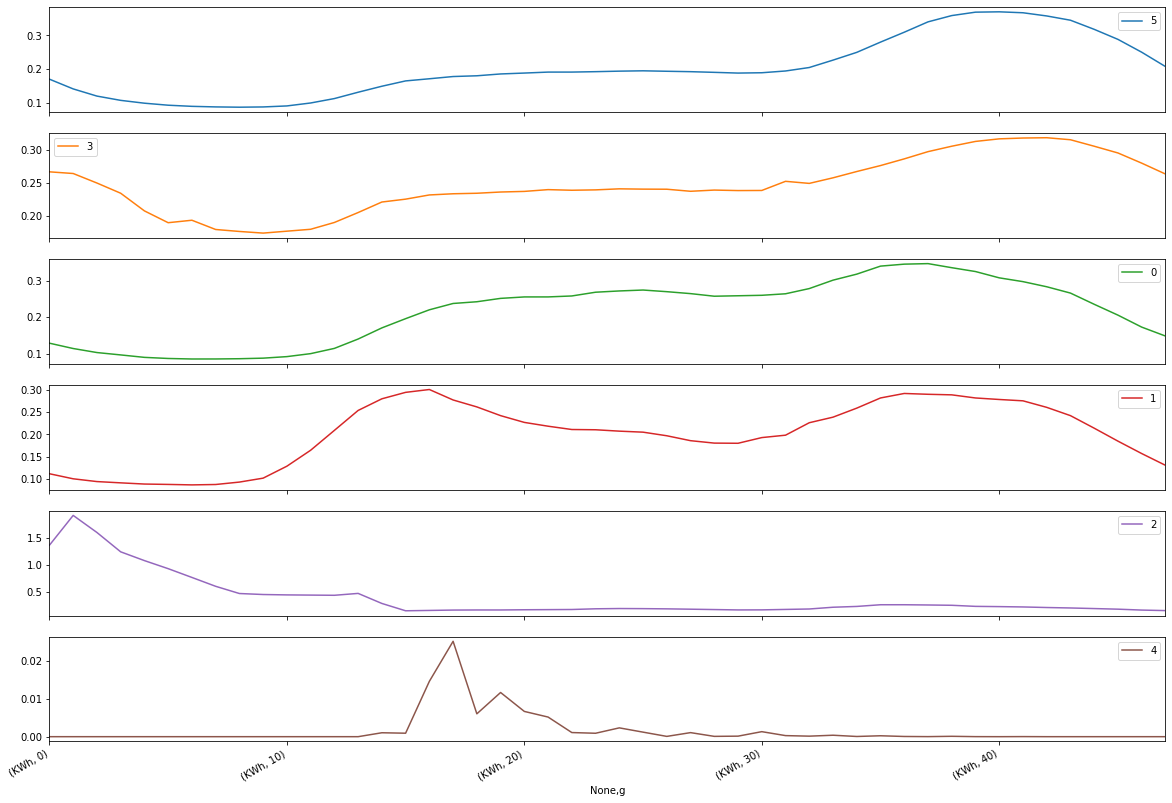

In [0]:
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
np.transpose(df3.groupby('clusters').mean().iloc[pd.array(pd.Series(clusters).value_counts().reset_index()['index']),0:len(df4)]).plot(subplots=True )
plt.show()

De nuevo, se observan patrones parecidos a los observados en los clústeres de medias por días, con grupos de individuos consumiendo en las jornadas nocturnas en su mayor parte.

# Cluster jerarquico

Por último, se lanzará un clúster jerárquico sobre la base de datos de la media por días.


In [0]:
df_s = df3.div(df4.sum(axis=1), axis=0)

In [0]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

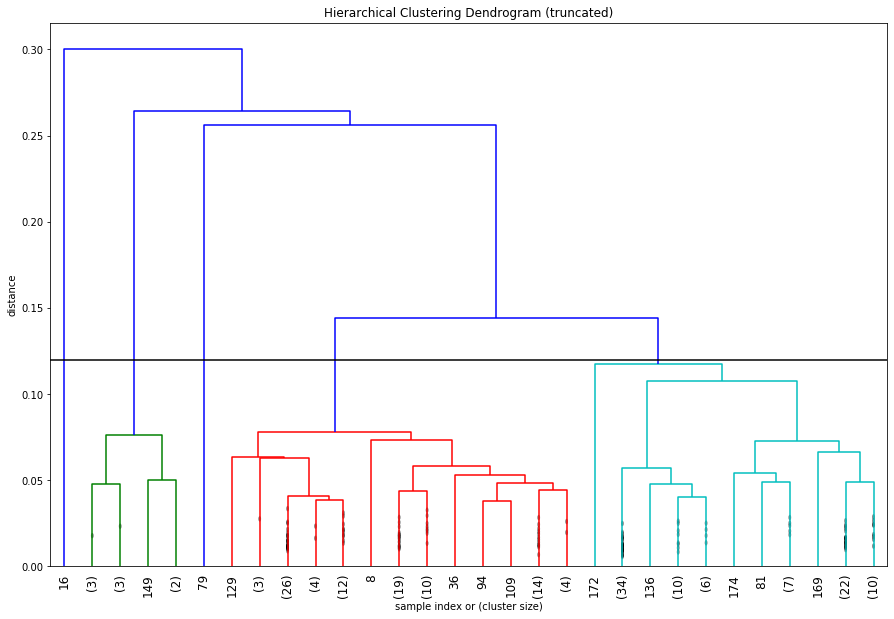

In [0]:
from sklearn import preprocessing
import matplotlib.pyplot as np
# s_scaler = preprocessing.StandardScaler()
# df_s = s_scaler.fit_transform(df3)

# df_s = pd.DataFrame(df_s, columns=df3.columns)
from scipy.cluster.hierarchy import dendrogram, ward
# from scipy.spatial import distance_wrap_

linked_array = ward(df_s)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.12
)

plt.show()

Se ha optado por realizar un corte en los 5 clústeres, pues las distancias que los separan parecen adecuadas

In [0]:
from scipy.cluster.hierarchy import fcluster
import numpy as np
max_d = 0.12
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

df4['clusters'] = clusters


print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    # print('rr: {}'.format(round(df[df['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 9

label: 2
n: 97

label: 3
n: 94

label: 4
n: 1

label: 5
n: 1


Existe de nuevo el problema de los outliers, así que se eliminarán de nuevo los individuos que peretenzcan al clúster 4 y 5

In [0]:
i = df4[((df4.clusters==4)|(df4.clusters==5))].index
df5 = df4.drop(i)
del df5['clusters']

In [0]:
df_s = df5.div(df5.sum(axis=1), axis=0)

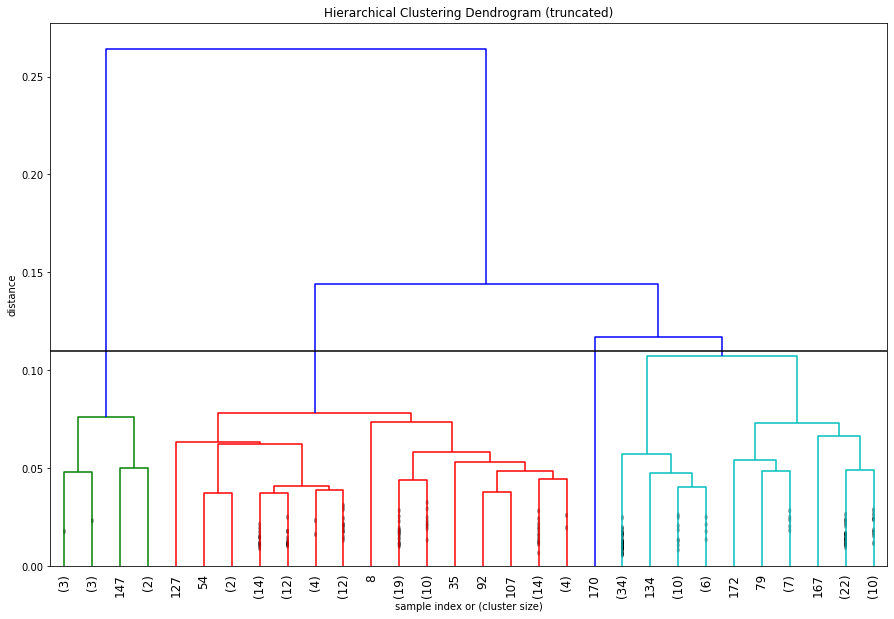

In [0]:
from sklearn import preprocessing
import matplotlib.pyplot as np
# s_scaler = preprocessing.StandardScaler()
# df_s = s_scaler.fit_transform(df3)

# df_s = pd.DataFrame(df_s, columns=df3.columns)
from scipy.cluster.hierarchy import dendrogram, ward
# from scipy.spatial import distance_wrap_

linked_array = ward(df_s)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.11
)

plt.show()

In [0]:
from scipy.cluster.hierarchy import fcluster
import numpy as np
max_d = 0.1
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

df5['clusters'] = clusters


print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    # print('rr: {}'.format(round(df[df['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 9

label: 2
n: 97

label: 3
n: 51

label: 4
n: 42

label: 5
n: 1


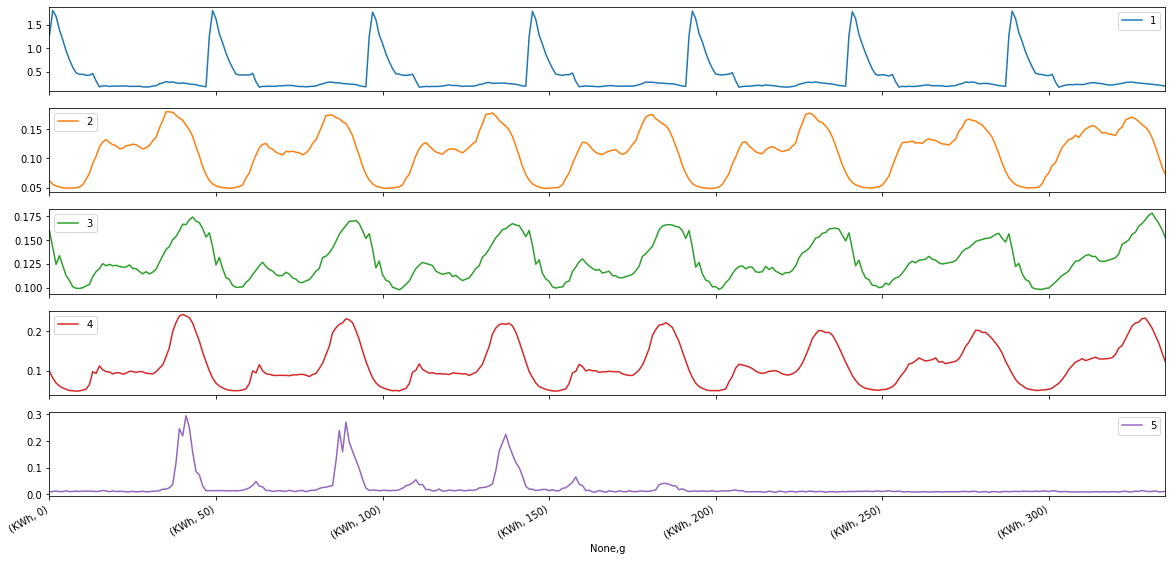

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]
np.transpose(df5.groupby('clusters').mean().iloc[[0,1,2,3,4],0:(len(df)-1)]).plot(subplots=True)
plt.show()

En este último clúster, se corrobora lo que lanzaba el kMeans en sus clústeres.

Mejoras a realizar:

Incluir las distintas variables que en un inicio tenían las series temporales

Comparar el clustering con las etiquetas que posee la base de datos inicial

Separar fines de semana de dias laborables, asi como de festivos

Encontrar una mejor manera de encontrar los outliers